In [20]:
#%config IPCompleter.use_jedi=False
%load_ext autoreload
%autoreload 2

In [21]:
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


from pandas._libs.tslibs.timestamps import Timestamp
from pandas.core.frame import DataFrame
from pandas.core.series import Series
from matplotlib.axes._axes import Axes
from numpy import ndarray

sys.path.append('..')
from cyclingEfficiency import CyclingEfficiency, Visualize
plt.style.use('seaborn-v0_8')

Como en el anterior notebook se vio que realmente existe una diferencia en la eficiencia dependiendo del terreno, el objetivo ahora es encontrar el mejor modelo para cada uno de los escenarios. Para estos casos se utilizarán el modelo de regresión lineal y bosques aleatorios. Para hacer todo el proceso más sencillo, se ha condensado toda la manipulación de datos hecha anteriormente en la clase "CyclingEfficiency" con el fin de hacer más sencillo el trabajo de pruebas. 

In [22]:
cad_step: int = 5

cyclingEfficiency: CyclingEfficiency = CyclingEfficiency(
    hr_max=190,
    bike_weight=11,
    cad_min=55,
    cad_max=100,
    cad_step=cad_step,
)

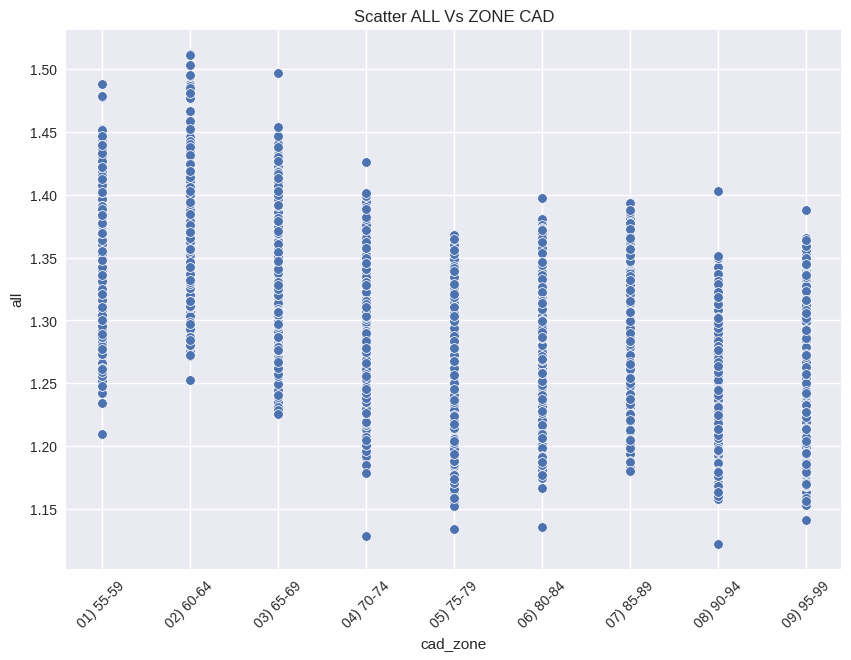

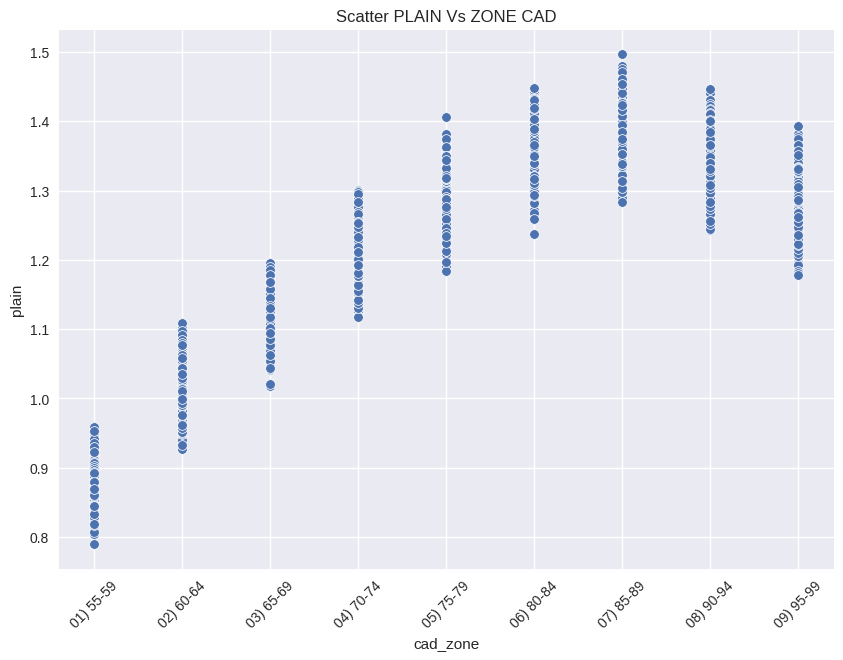

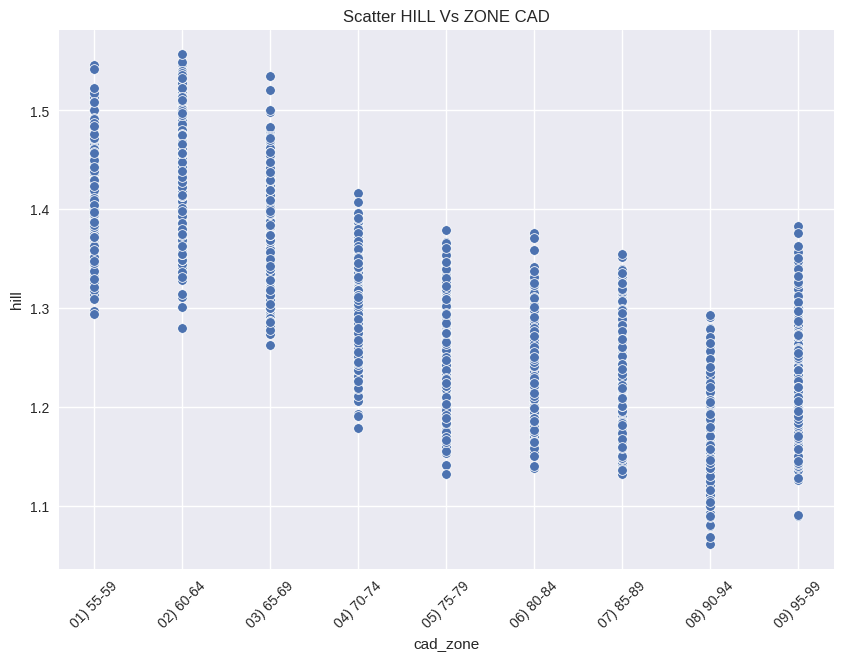

In [23]:
columns = ['all', 'plain', 'hill']
for variable in columns:
    plt.figure(figsize=(10, 7))
    graph = sns.scatterplot(
        data=cyclingEfficiency.samples,
        x='cad_zone',
        y=variable
    )
    
    graph.tick_params(axis='x', labelrotation = 45)

    plt.title('Scatter {} Vs ZONE CAD'.format(variable.upper()))
    plt.show()

In [24]:
cyclingEfficiency.samples['cad_zone_num_2'] = cyclingEfficiency.samples['cad_zone_num'] ** 2
cyclingEfficiency.samples['cad_zone_num_3'] = cyclingEfficiency.samples['cad_zone_num'] ** 3

In [25]:
def graph_model(
    data: DataFrame, X: DataFrame, y_pred: Series, variable: str, 
    cad_zone: ndarray 
):
    cad_zone.sort()

    plt.figure(figsize=(10, 7))
    graph = sns.scatterplot(
        data=data,
        x='cad_zone_num',
        y=variable,
        label='y_test',
        color='#3333CC'
    )

    graph.set_xticks(
        range(1, len(cad_zone) + 1),
        cad_zone
    )

    graph.set_xticklabels(
        graph.get_xticklabels(), rotation=45,
        horizontalalignment='right'
    )
        
    graph = plt.plot(
        X['cad_zone_num'],
        y_pred,
        label='y_pred',
        color='#CC3333'
    )

    plt.legend()
    plt.title('Scatter {} Vs ZONE CAD'.format(variable.upper()))
    plt.show()

## Model Plain

In [26]:
variable: str = 'plain'
x_variables: list[str] = [
    'cad_zone_num', 'cad_zone_num_2',
]
formula_x = ' + '.join(x_variables)

x_train, x_test, y_train, y_test = train_test_split(
    cyclingEfficiency.samples[x_variables],
    cyclingEfficiency.samples[variable],
)

data_train: DataFrame = pd.concat([x_train, y_train],axis=1)
data_test: DataFrame = pd.concat([x_test, y_test],axis=1)

model_plain = (
    smf.ols(
        formula=variable + ' ~ ' + formula_x,
        data=data_train
    ).fit()
)

max_value: int = data_train['cad_zone_num'].max()
x: list[int] = [
    (i + 1, (i + 1)**2,) for i in range(max_value)
]

X: DataFrame = pd.DataFrame(
    x,
    columns=x_variables
)

y_pred_plain: ndarray = model_plain.predict(X)

model_plain.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  plain   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 7.230e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:53:53   Log-Likelihood:                 13009.
No. Observations:                6750   AIC:                        -2.601e+04
Df Residuals:                    6747   BIC:                        -2.599e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6846      0.002    420.104      0.000       0.681       0.688
cad_zone_num       0.1904      0.001    254.059      0.000       0.189       0.192
cad_zone_num_2    -0.0135    7.3e-05   -185.425      0.000      -0.014      -0.013
==============================================================================
Omnibus:                        2.153   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                2.189
Skew:                           0.040   Prob(JB):                        0.335
Kurtosis:                       2.963   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
print('Model plain',r2_score(y_test, model_plain.predict(x_test)))

Model plain 0.9543607582374557


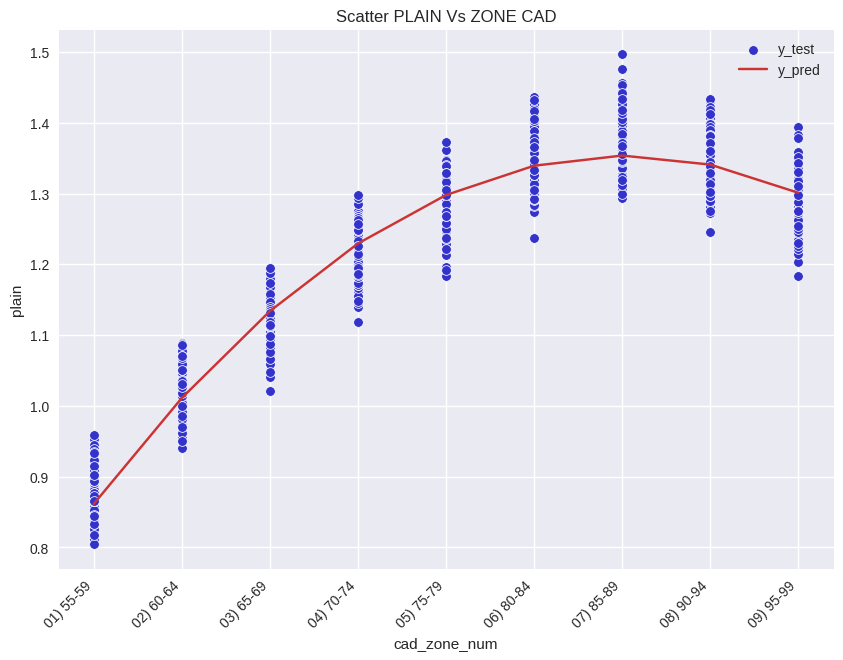

In [28]:
graph_model(
    data_test, X, y_pred_plain, variable, cyclingEfficiency.cad_zones
)

## Model Hill

In [29]:
variable: str = 'hill'
x_variables: list[str] = [
    'cad_zone_num', 'cad_zone_num_2',
    'cad_zone_num_3', 
]
formula_x = ' + '.join(x_variables)

x_train, x_test, y_train, y_test = train_test_split(
    cyclingEfficiency.samples[x_variables],
    cyclingEfficiency.samples[variable],
)

data_train: DataFrame = pd.concat([x_train, y_train], axis=1)
data_test: DataFrame = pd.concat([x_test, y_test], axis=1)

model_hill = (
    smf.ols(
        formula= variable + ' ~ ' + formula_x,
        data=data_train
    ).fit()
)

max_value: int = cyclingEfficiency.samples['cad_zone_num'].max()
x: list[int] = [
    (i + 1, (i + 1)**2, (i + 1)**3,) 
    for i in range(max_value)
]

X: DataFrame = pd.DataFrame(
    x,
    columns=x_variables
)

y_pred_hill: ndarray = model_hill.predict(X)

model_hill.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hill   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     7413.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:53:53   Log-Likelihood:                 11520.
No. Observations:                6750   AIC:                        -2.303e+04
Df Residuals:                    6746   BIC:                        -2.300e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4225      0.003    409.395      0.000       1.416       1.429
cad_zone_num       0.0137      0.003      4.829      0.000       0.008       0.019
cad_zone_num_2    -0.0147      0.001    -22.842      0.000      -0.016      -0.013
cad_zone_num_3     0.0012   4.26e-05     28.146      0.000       0.001       0.001
==============================================================================
Omnibus:                       17.915   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.052
Skew:                           0.125   Prob(JB):                     0.000120
Kurtosis:                       2.963   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

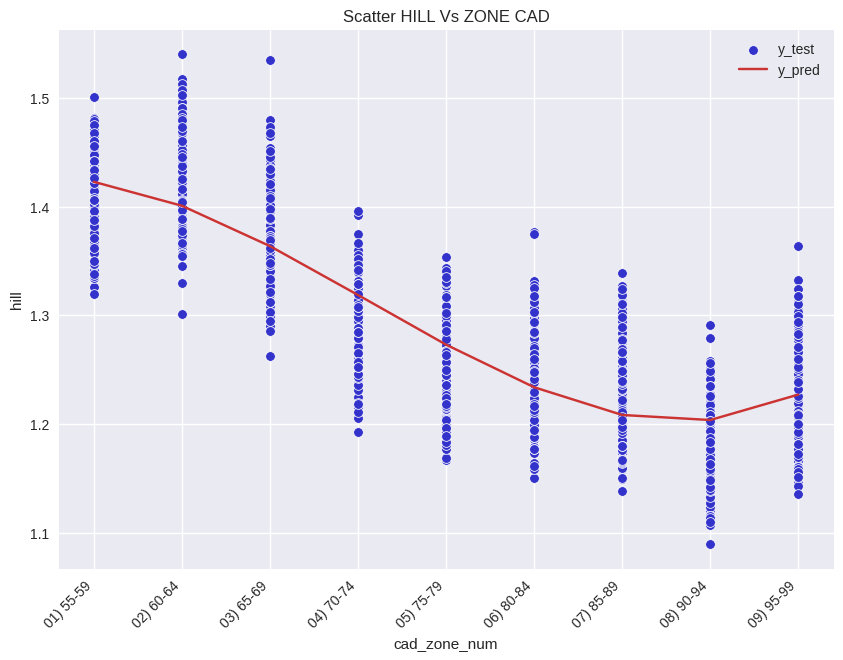

In [30]:
graph_model(
    data_test, X, y_pred_hill, variable, cyclingEfficiency.cad_zones
)

In [31]:
x_variables_model_2: list[str] = [
    'cad_zone_num', 
]

x_train_model_2, x_test_model_2, y_train_model_2, y_test_model_2 = train_test_split(
    cyclingEfficiency.samples[x_variables_model_2],
    cyclingEfficiency.samples[variable],
)

data_train_model_2: DataFrame = pd.concat([x_train_model_2, y_train_model_2], axis=1)
data_test_model_2: DataFrame = pd.concat([x_test_model_2, y_test_model_2], axis=1)

x: list[int] = [
    (i + 1, ) 
    for i in range(max_value)
]

X_model_2: DataFrame = pd.DataFrame(
    x,
    columns=x_variables_model_2
)

model_hill_2 = RandomForestRegressor(n_estimators=1000, max_depth=4)
model_hill_2.fit(x_train_model_2, y_train_model_2)

y_pred_hill_2: ndarray = model_hill_2.predict(X_model_2)

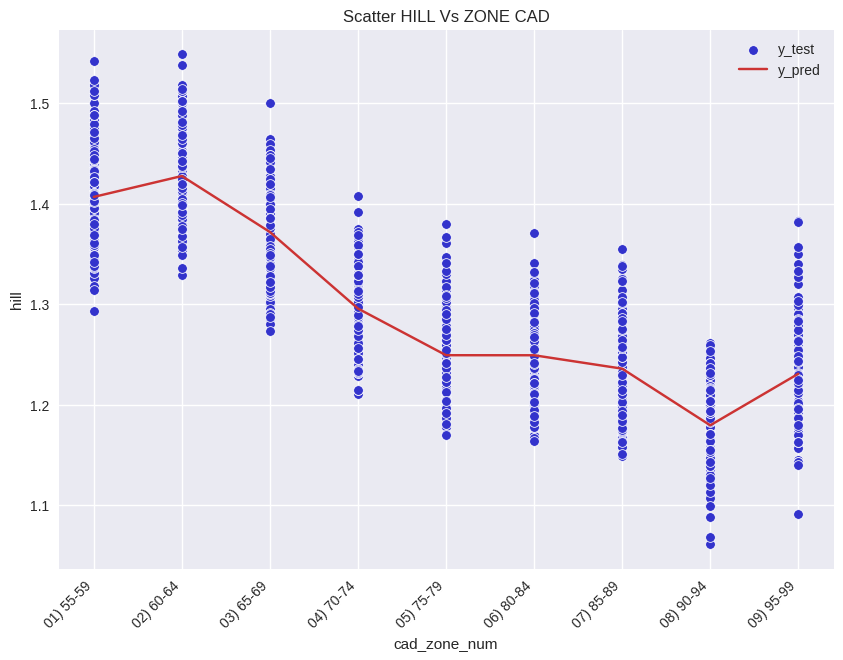

In [32]:
graph_model(
    data_test_model_2, X_model_2, y_pred_hill_2, 
    variable, cyclingEfficiency.cad_zones
)

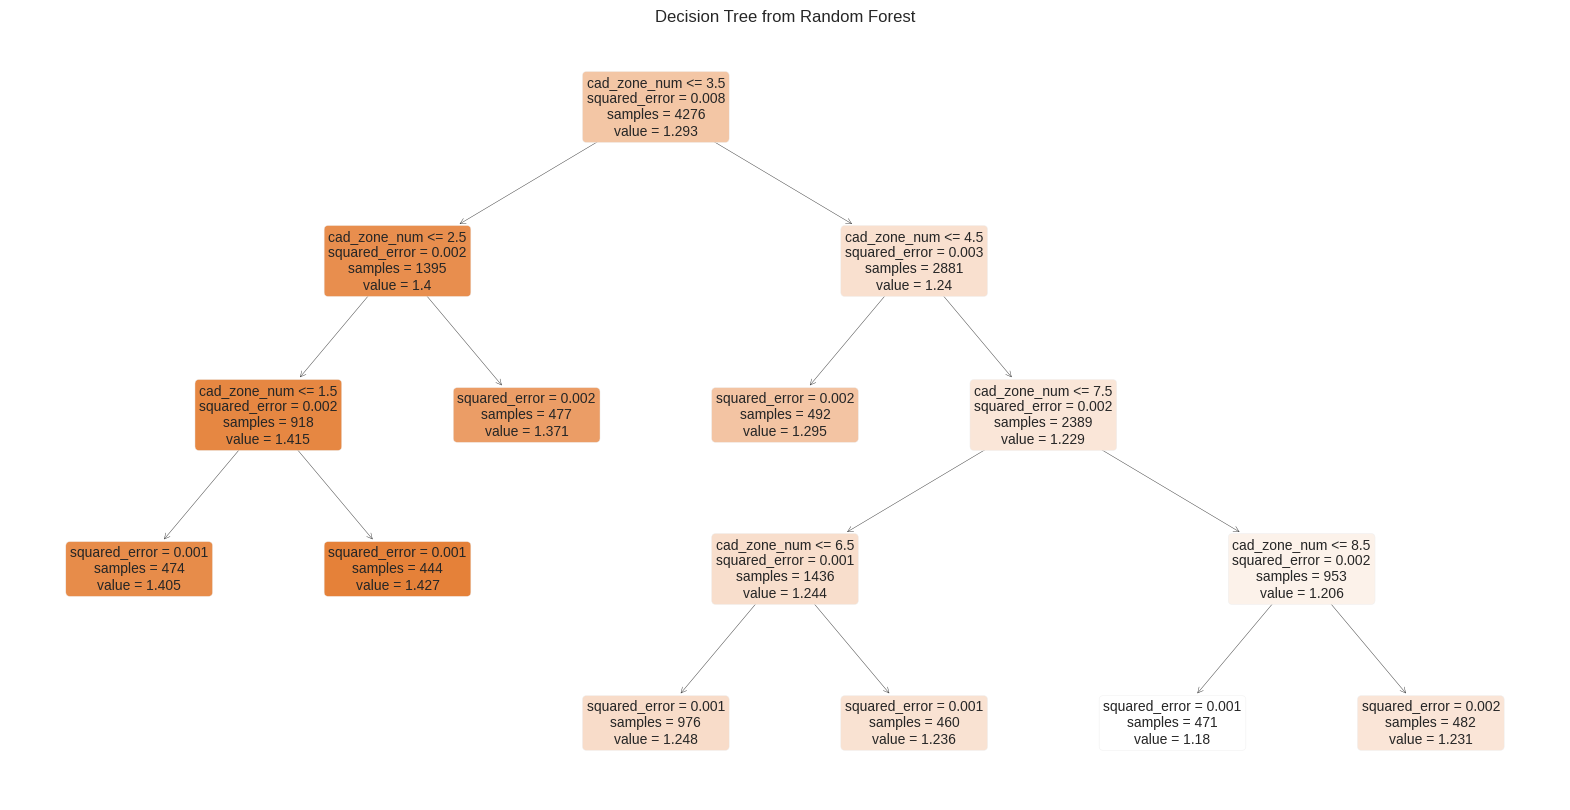

In [33]:
from sklearn.tree import plot_tree
model_hill_2.estimators_[0]

tree_to_plot = model_hill_2.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=data_test.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [34]:
print('Model 1',r2_score(y_test, model_hill.predict(x_test)))
print('Model 2',r2_score(y_test_model_2, model_hill_2.predict(x_test_model_2)))

Model 1 0.774984335054447
Model 2 0.8147927460978946


# Conclusiones

In [35]:
margen_value: float = 0.05

In [36]:
# Plain
cad_zone_max_name_plain: str = cyclingEfficiency.cad_zones[
            np.argmax(y_pred_plain)
        ]
cad_zone_max_plain: int = np.max(y_pred_plain)

print(
    '''El rango de cadencia mas eficiente en el terreno plano es {}
    y puede generar un promedio de eficiencia de {:.4f}'''.format(
        cad_zone_max_name_plain[4:],
        cad_zone_max_plain,
))

El rango de cadencia mas eficiente en el terreno plano es 85-89
    y puede generar un promedio de eficiencia de 1.3536


In [37]:
cyclingEfficiency.data[
    (cyclingEfficiency.data['is_plain'] == 1) &
    (cyclingEfficiency.data['cad_zone'] == cad_zone_max_name_plain) &
    (cyclingEfficiency.data['performance_indicator'] > (cad_zone_max_plain * (1 - margen_value))) &
    (cyclingEfficiency.data['performance_indicator'] < (cad_zone_max_plain * (1 + margen_value)))
].sample(10)


,secs,cad,hr,km,kph,watts,alt,lon,lat,slope,...,weight,zones,is_plain,w,w_hr,w_kg,w_kg_hr,performance_indicator,cad_zone,cad_zone_num
185178,16866,87.0,141.0,65.5561,33.2892,0.0,2610.0,-74.213043,4.808105,0.523810,...,61.2,2,1,165.127555,1.171117,2.698163,0.019136,1.349081,07) 85-89,7
123635,1994,88.0,98.0,9.7392,21.1752,0.0,2593.8,-74.220568,4.823176,0.000000,...,62.2,1,1,84.390230,0.861125,1.356756,0.013844,1.356756,07) 85-89,7
4681,10991,89.0,123.0,54.1809,28.7280,0.0,2630.8,-74.175790,4.913200,0.904762,...,64.6,2,1,171.733800,1.396210,2.658418,0.021613,1.329209,07) 85-89,7
460364,5590,85.0,148.0,38.9108,31.7592,0.0,2573.6,-74.195193,4.788201,0.714286,...,62.7,2,1,172.947110,1.168562,2.758327,0.018637,1.379164,07) 85-89,7
302964,2778,87.0,137.0,13.7472,36.7092,0.0,2606.0,-74.259096,4.840492,0.350901,...,62.2,2,1,171.966368,1.255229,2.764733,0.020181,1.382366,07) 85-89,7
161084,1016,86.0,99.0,4.8430,21.1680,0.0,2585.6,-74.198798,4.790901,0.000000,...,64.6,1,1,87.127488,0.880076,1.348723,0.013623,1.348723,07) 85-89,7
129073,15410,85.0,115.0,64.5480,21.1680,0.0,2595.0,-74.222870,4.816915,0.000000,...,62.2,1,1,84.361536,0.733579,1.356295,0.011794,1.356295,07) 85-89,7
239436,4926,88.0,141.0,21.4336,40.8852,0.0,2586.2,-74.108556,4.661250,0.010991,...,62.2,2,1,163.836593,1.161962,2.634029,0.018681,1.317014,07) 85-89,7
233785,497,85.0,101.0,2.1440,20.8800,40.0,2540.0,0.000000,0.000000,0.000000,...,70.6,1,1,92.762880,0.918444,1.313922,0.013009,1.313922,07) 85-89,7
53180,5150,85.0,114.0,33.7436,21.1752,0.0,2569.2,-74.157051,4.759497,0.000000,...,64.0,1,1,86.465400,0.758468,1.351022,0.011851,1.351022,07) 85-89,7


In [38]:
# Hill
cad_zone_max_name_hill: str = cyclingEfficiency.cad_zones[
            np.argmax(y_pred_hill_2)
        ]
cad_zone_max_hill: int = np.max(y_pred_hill_2)
print(
    '''El rango de cadencia mas eficiente en montaña es {}
    y puede generar un promedio de eficiencia de {:.4f}'''.format(
        cad_zone_max_name_hill[4:],
        cad_zone_max_hill,
))

El rango de cadencia mas eficiente en montaña es 60-64
    y puede generar un promedio de eficiencia de 1.4275


In [39]:
cyclingEfficiency.data[
    (cyclingEfficiency.data['is_plain'] == 0) &
    (cyclingEfficiency.data['cad_zone'] == cad_zone_max_name_hill) &
    (cyclingEfficiency.data['performance_indicator'] > (cad_zone_max_hill * (1 - margen_value))) &
    (cyclingEfficiency.data['performance_indicator'] < (cad_zone_max_hill * (1 + margen_value)))
].sample(10)

,secs,cad,hr,km,kph,watts,alt,lon,lat,slope,...,weight,zones,is_plain,w,w_hr,w_kg,w_kg_hr,performance_indicator,cad_zone,cad_zone_num
36544,4444,62.0,138.0,25.2020,24.120,0.0,805.8,-74.415760,5.065976,1.72546,...,63.5,2,0,182.224648,1.320468,2.869679,0.020795,1.434840,02) 60-64,2
399410,10298,60.0,131.0,42.4654,9.072,0.0,1748.4,-74.310236,4.975485,8.09524,...,62.3,2,0,182.267913,1.391358,2.925649,0.022333,1.462824,02) 60-64,2
111839,4852,62.0,133.0,22.1011,9.072,0.0,1095.0,-74.349017,5.016567,7.61905,...,63.2,2,0,175.860152,1.322257,2.782597,0.020922,1.391299,02) 60-64,2
610486,13905,63.0,127.0,43.8642,9.072,0.0,1185.2,-74.341287,4.996687,8.09524,...,63.4,2,0,185.003175,1.456718,2.918031,0.022977,1.459016,02) 60-64,2
559121,10653,64.0,150.0,47.2228,10.584,0.0,1410.0,-74.455360,4.635669,6.66667,...,63.5,2,0,185.712608,1.238084,2.924608,0.019497,1.462304,02) 60-64,2
113778,6858,63.0,132.0,28.0254,9.072,0.0,1392.8,-74.323090,4.992999,8.06789,...,63.2,2,0,184.009552,1.394012,2.911544,0.022057,1.455772,02) 60-64,2
398373,3706,63.0,136.0,18.0608,9.072,0.0,2764.2,-74.290131,4.860121,8.09524,...,62.3,2,0,182.267913,1.340205,2.925649,0.021512,1.462824,02) 60-64,2
485472,18510,64.0,138.0,66.0774,16.632,0.0,2618.8,-74.211543,4.805896,3.32280,...,63.0,2,0,178.274961,1.291848,2.829761,0.020506,1.414881,02) 60-64,2
119272,13281,63.0,151.0,46.6487,10.584,0.0,2402.2,-74.302239,4.908740,6.66667,...,63.2,2,0,184.964772,1.224932,2.926658,0.019382,1.463329,02) 60-64,2
435322,6703,61.0,143.0,14.6630,9.072,0.0,1066.0,-74.969279,5.183973,8.09524,...,66.9,2,0,193.706282,1.354589,2.895460,0.020248,1.447730,02) 60-64,2


En resumen, si existe diferencia entre el terreno llano y el terreno con desnivel, para cada uno existe una cadencia óptima diferente. Esos puntos indican que en ese nivel de cadencia respectivo se puede llegar a generar el esfuerzo mayor con el menor desgaste posible.

Para futuros análisis, se podría validar si, dependiendo del grado de pendiente, puede cambiar el resultado, además de validar si con los datos de otros ciclistas los valores cambian o se mantienen. También sería importante agregar al modelo el efecto del desgaste físico y la altitud a la que se está trabajando.